<a href="https://colab.research.google.com/github/asmitanaitam/Radon_Mapping/blob/main/Radon_Mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
ee.Authenticate()
ee.Initialize(project='my-project-radon-mapping')  # Replace this


In [2]:
import geemap
import ee

# Define region of interest
roi = {
    "min_lon": -84.6,
    "max_lon": -84.2,
    "min_lat": 33.6,
    "max_lat": 33.9,
}

# Create a geemap map
m = geemap.Map(center=[33.75, -84.4], zoom=10)

# Load Sentinel-2 imagery
sentinel = ee.ImageCollection('COPERNICUS/S2') \
    .filterDate('2022-06-01', '2022-08-01') \
    .filterBounds(ee.Geometry.BBox(
        roi["min_lon"], roi["min_lat"], roi["max_lon"], roi["max_lat"]
    )) \
    .median() \
    .select(['B4', 'B3', 'B2'])  # RGB bands

# Add image layer
m.addLayer(sentinel, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Sentinel-2 RGB')

# Add bounding box as ee.Feature
bbox = ee.Geometry.Rectangle([
    roi["min_lon"], roi["min_lat"],
    roi["max_lon"], roi["max_lat"]
])
m.addLayer(bbox, {'color': 'red'}, 'ROI Box')

m


Map(center=[33.75, -84.4], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [6]:
import leafmap.foliumap as leafmap  # Safe backend for Colab
m = leafmap.Map()
m.add_basemap("SATELLITE")
m


In [19]:
from google.colab import output
output.enable_custom_widget_manager()

Load Shapefile and Spreadsheet

In [6]:
import pandas as pd

df = pd.read_excel("/content/radon_zones-spreadsheet.xls", skiprows=2)
print(df.columns.tolist())


['ALABAMA', 'no data', 'no data.1', '.', '..1', 'Unnamed: 5', 'Unnamed: 6']


In [8]:
import pandas as pd

# Load file, skip first 3 rows (adjust if needed)
df_raw = pd.read_excel("/content/radon_zones-spreadsheet.xls", skiprows=3, header=None)

# Manually assign column names
df_raw.columns = ['County,State', 'COUNTY LABEL', 'STATE', 'Region', 'Zone', 'Unnamed1', 'Unnamed2']

# Drop unnecessary columns
df = df_raw[['STATE', 'COUNTY LABEL', 'Zone']].dropna()

# Clean values
df['STATE'] = df['STATE'].str.upper().str.strip()
df['COUNTY'] = df['COUNTY LABEL'].str.upper().str.replace(" COUNTY", "", regex=False).str.strip()
#df['ZONE'] = df['Zone'].astype(int)
# Keep only rows where Zone is 1, 2, or 3
df = df[df['Zone'].isin([1, 2, 3])]
df['ZONE'] = df['Zone'].astype(int)


# Final cleaned dataframe
df = df[['STATE', 'COUNTY', 'ZONE']]
print(df.head())


     STATE    COUNTY  ZONE
0  ALABAMA  .AUTAUGA     2
1  ALABAMA  .BALDWIN     3
2  ALABAMA  .BARBOUR     2
3  ALABAMA     .BIBB     2
4  ALABAMA   .BLOUNT     2


In [9]:
import geopandas as gpd

# Load county shapefile
gdf = gpd.read_file("/content/cb_2022_us_county_20m.shp")

# Convert county and state names to uppercase and remove extra spaces
gdf['STATE'] = gdf['STATE_NAME'].str.upper().str.strip()
gdf['COUNTY'] = gdf['NAME'].str.upper().str.strip()


Merge shapefile with radon zone data

In [10]:
# Merge shapefile with radon data
merged_gdf = gdf.merge(df, on=['STATE', 'COUNTY'], how='left')


Plot the map colored by radon zone

In [17]:
# Remove leading periods, convert to uppercase, and strip spaces
df['COUNTY'] = df['COUNTY'].str.replace('.', '', regex=False)
df['COUNTY'] = df['COUNTY'].str.replace(' COUNTY', '', regex=False).str.upper().str.strip()
df['STATE'] = df['STATE'].str.upper().str.strip()


In [18]:
gdf['NAME'] = gdf['NAME'].str.upper().str.strip()
gdf['STATE_NAME'] = gdf['STATE_NAME'].str.upper().str.strip()


In [19]:
merged_gdf = gdf.merge(df, left_on=['NAME', 'STATE_NAME'], right_on=['COUNTY', 'STATE'], how='left')
print("Merged rows:", len(merged_gdf))
print("Missing ZONEs:", merged_gdf['ZONE'].isna().sum())


Merged rows: 3222
Missing ZONEs: 235


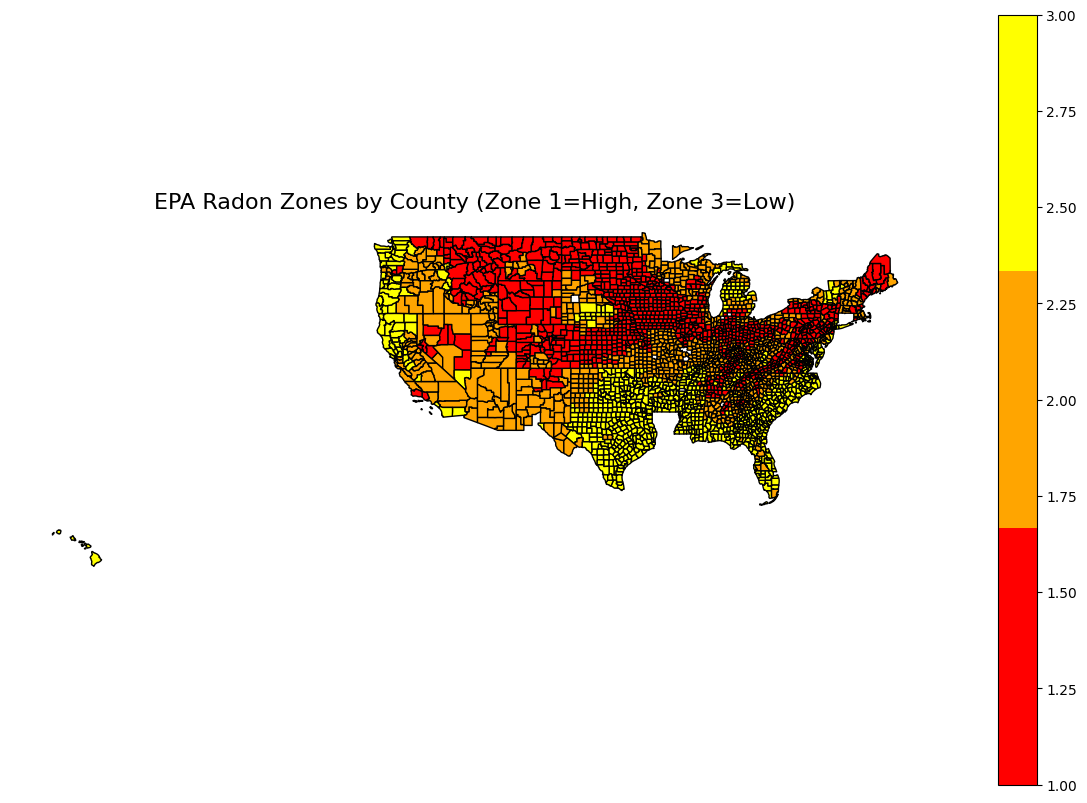

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Keep only rows with valid geometries and known radon zones
plot_gdf = merged_gdf.dropna(subset=['ZONE'])
plot_gdf = plot_gdf[plot_gdf.geometry.notnull() & plot_gdf.geometry.is_valid & ~plot_gdf.geometry.is_empty]

# Plot
fig, ax = plt.subplots(figsize=(15, 10))
plot_gdf.plot(column='ZONE',
              ax=ax,
              cmap=mcolors.ListedColormap(['red', 'orange', 'yellow']),
              legend=True,
              edgecolor='black')

ax.set_title("EPA Radon Zones by County (Zone 1=High, Zone 3=Low)", fontsize=16)
plt.axis('off')
plt.show()


<Axes: >

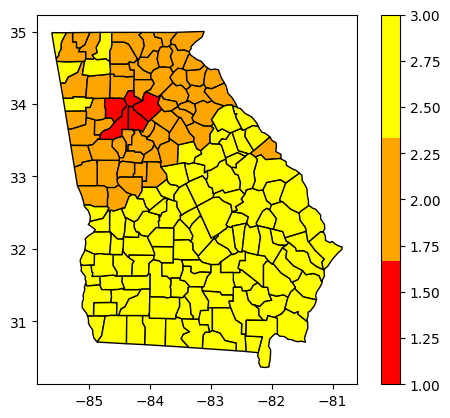

In [21]:
ga = plot_gdf[plot_gdf['STATE_NAME'] == 'GEORGIA']
ga.plot(column='ZONE',
        cmap=mcolors.ListedColormap(['red', 'orange', 'yellow']),
        legend=True,
        edgecolor='black')


In [22]:
shapefile_path = "/content/radon_zones_by_county.shp"
merged_gdf.to_file(shapefile_path)


In [23]:
import shutil

shapefile_dir = "/content/radon_shapefile_export"
merged_gdf.to_file(shapefile_dir)
shutil.make_archive("/content/radon_shapefile_export", 'zip', shapefile_dir)


'/content/radon_shapefile_export.zip'

In [25]:
from google.colab import files

geojson_path = "/content/radon_zones_by_county.geojson"
merged_gdf.to_file(geojson_path, driver='GeoJSON')
files.download(geojson_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
!pip install folium rasterio geopandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 70.8 MB/s eta 0:00:00


In [27]:
import folium
import geopandas as gpd


In [28]:
merged_gdf_simplified = merged_gdf.to_crs(epsg=4326).simplify(0.01)


In [34]:
import folium

# Create the map centered on Georgia
m = folium.Map(location=[33.0, -84.0], zoom_start=6)

# Add GeoJSON overlay (corrected tooltip fields)
folium.GeoJson(
    "/content/radon_zones_by_county.geojson",
    name="Radon Zones",
    tooltip=folium.GeoJsonTooltip(fields=["STATE_x", "COUNTY_x", "ZONE"]),
    style_function=lambda feature: {
        "fillColor": {
            1: "red",
            2: "orange",
            3: "yellow"
        }.get(feature["properties"]["ZONE"], "gray"),
        "color": "black",
        "weight": 0.5,
        "fillOpacity": 0.7,
    },
).add_to(m)

m


In [35]:
m.save("/content/epa_radon_map.html")
from google.colab import files
files.download("/content/epa_radon_map.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
import folium

m = folium.Map(
    location=[33.0, -84.0],  # Centered on Georgia
    zoom_start=6,
    tiles="https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png",
    attr="Tiles © OpenStreetMap contributors"
)

m


In [38]:
import folium

# Create base map centered on Georgia
m = folium.Map(
    location=[33.0, -84.0],
    zoom_start=6,
    tiles="https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png",
    attr="Tiles © OpenStreetMap contributors"
)

# Add the GeoJSON overlay for radon zones
folium.GeoJson(
    "radon_zones_by_county.geojson",
    name="EPA Radon Zones",
    tooltip=folium.GeoJsonTooltip(fields=['COUNTY_x', 'STATE_x', 'ZONE'], aliases=['County:', 'State:', 'Zone:']),
    style_function=lambda x: {
        'fillColor': {1: 'red', 2: 'orange', 3: 'yellow'}.get(x['properties']['ZONE'], 'gray'),
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7,
    }
).add_to(m)

# Add layer control (optional)
folium.LayerControl().add_to(m)

# Display the map
m
